# Summarizing data with PCA

This activity is meant to explore the results of applying PCA to a dataset.  Below, a dataset from a credit card company is loaded and displayed.  This dataset contains customer data pertaining to demographic and payment information as well as basic demographics.  The final column `default payment next month` is what we want to create profiles for.  

You are to use PCA and reduce the dimensionality of the data to 2 and 3 dimensions.  Then, draw scatterplots of the resulting data and color them by `default`.  Does it seem that 2 or 3 principal components will seperate the data into clear groups?  Why or why not?  You should post your visualizations and argument for whether the components offer more succinct data representations on the discussion board for this activity.  (Note: In this assignment you should use the sklearn version of `PCA`.)

## Imports

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

# import seaborn as sns

In [68]:
pd.set_option("display.max_columns", None)

## Data Load and Display

### Load

In [69]:
df_in = pd.read_csv("./data/credit.csv")

### Cleanup

In [70]:
target_var = "default"
df = df_in.rename(columns={"default.payment.next.month": target_var}).drop(columns="ID")

### Display

In [71]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Correlation Coefficients as Heatmap

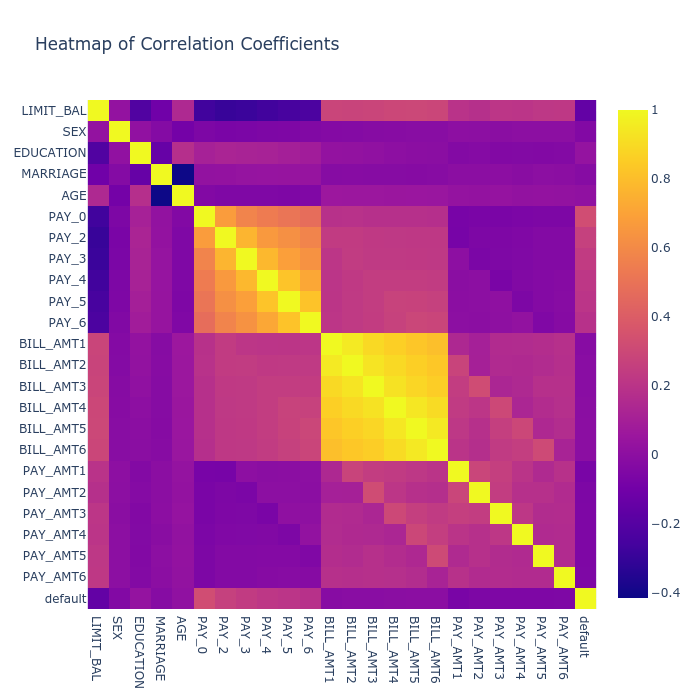

In [72]:
# sns.heatmap(df.corr(), annot=False)
fig = px.imshow(
    df.corr(), title="Heatmap of Correlation Coefficients", height=700, width=700
)

# fig.show()
Image(fig.to_image())

### Observations

Notice lots of lines of constant color and even constant blocks of color
- So cc same vs several contiguous variables
- i.e. there is lots of redundancy in the data

## Perform the PCA

### Remove Target Variable

In [73]:
df_for_pca = df.drop(columns=target_var)

### Scale

In [74]:
scaling = StandardScaler()
scaling.fit(df_for_pca)
df_scaled = scaling.transform(df_for_pca)

### Fit

In [75]:
pca = PCA(n_components=df_scaled.shape[1]).fit(df_scaled)

## PCA Analysis

### Explained Variance

#### Extract

In [76]:
ev_ratio = pca.explained_variance_ratio_ * 100.0
cum_ev_ratio = ev_ratio.cumsum()

#### Verify

In [77]:
X_tilde = pca.fit_transform(df_scaled)
ev = np.apply_along_axis(np.var, 0, X_tilde)  # using unbiased variance
ev_ratio_check = ev / ev.sum() * 100.0
display([ev_ratio[:5], ev_ratio_check[:5]])

[array([28.44821453, 17.81881699,  6.74330708,  6.40115401,  4.45755634]),
 array([28.44821453, 17.81881699,  6.74330708,  6.40115401,  4.45755634])]

#### Relation to Singular Values

In [78]:
ev_from_sv = pca.singular_values_**2 / (len(df) - 1)  # using unbiased variance
display(
    [
        ev_from_sv[:5],
        pca.explained_variance_[:5],
        np.allclose(ev_from_sv, pca.explained_variance_),
    ]
)

[array([6.54330745, 4.09846452, 1.55101233, 1.4723145 , 1.02527213]),
 array([6.54330745, 4.09846452, 1.55101233, 1.4723145 , 1.02527213]),
 True]

### Num Components for Minimum Explained Variance

In [79]:
min_ev_ratio_pct = 80.0
ncomp_for_ev = np.argmax(cum_ev_ratio >= min_ev_ratio_pct) + 1
display([ncomp_for_ev, cum_ev_ratio[ncomp_for_ev - 1]])

[10, 83.02810480357901]

#### Verify Using Built-In Capability

In [80]:
ncomp_check = PCA(n_components=min_ev_ratio_pct / 100.0).fit(df_scaled).n_components_
assert (
    ncomp_for_ev == ncomp_check
), "Disagreement on Number of Components for 80% Variance"

### Plot

[None, None, None]

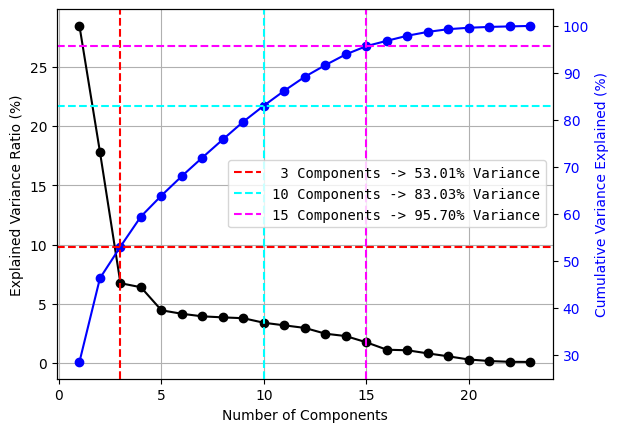

In [81]:
fig, ax1 = plt.subplots()

ax1_color = "black"
ax1.plot(
    np.arange(len(ev_ratio)) + 1,
    ev_ratio,
    linestyle="solid",
    marker="o",
    color=ax1_color,
)

ax1.grid(True)
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Explained Variance Ratio (%)", color=ax1_color)

ax2_color = "blue"
ax2 = ax1.twinx()
ax2.plot(
    np.arange(len(cum_ev_ratio)) + 1,
    cum_ev_ratio,
    linestyle="solid",
    marker="o",
    color=ax2_color,
)

ax2.set_ylabel("Cumulative Variance Explained (%)", color=ax2_color)
ax2.tick_params(axis="y", labelcolor=ax2_color)


def crosshairs_at_ev(
    target_ev_pct: float = 0.0, color: str = "", linestyle: str = "--"
):
    ncomp = PCA(n_components=target_ev_pct / 100.0).fit(df_scaled).n_components_
    label = "%2d Components -> %.2f%% Variance" % (ncomp, cum_ev_ratio[ncomp - 1])
    ax2.axhline(cum_ev_ratio[ncomp - 1], color=color, linestyle=linestyle)
    ax2.axvline(ncomp, label=label, color=color, linestyle=linestyle)


crosshairs_at_ev(target_ev_pct=50.0, color="red")
crosshairs_at_ev(target_ev_pct=80.0, color="cyan")
crosshairs_at_ev(target_ev_pct=95.0, color="magenta")

plt.setp(plt.legend(loc="center right", fancybox=True).texts, family="monospace")

## PCA with 2 Components

### Fit

In [82]:
df_pca_2 = pd.DataFrame(
    PCA(n_components=2).fit_transform(df_scaled),
    columns=["pca" + str(k + 1) for k in range(2)],
).join(df[target_var])
# df_pca_2.head()

### Plot

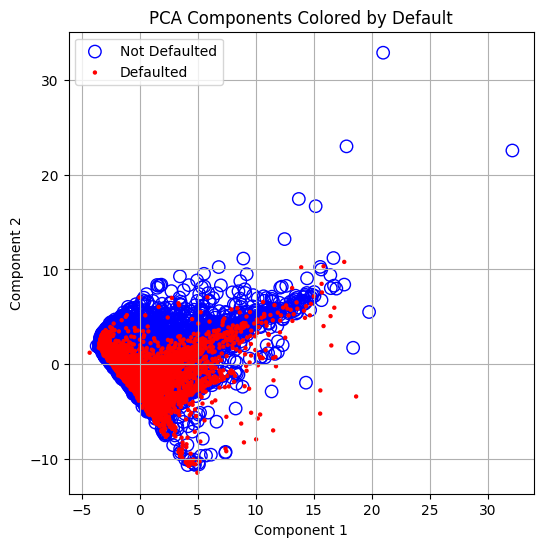

In [83]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    df_pca_2.query("default == 0").iloc[:, 0],
    df_pca_2.query("default == 0").iloc[:, 1],
    color="blue",
    label="Not Defaulted",
    s=80,
    facecolors="none",
    edgecolors="blue",
)

ax.scatter(
    df_pca_2.query("default == 1").iloc[:, 0],
    df_pca_2.query("default == 1").iloc[:, 1],
    color="red",
    s=10,
    facecolors="red",
    edgecolors="none",
    label="Defaulted",
)

ax.grid(True)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
plt.title("PCA Components Colored by Default")
plt.legend()

### Analysis

With 2 features the data is quite mixed up. Little hard to tell at first because the dots are on top of each other

## PCA with 3 Components

### Fit

In [84]:
df_pca_3 = pd.DataFrame(
    PCA(n_components=3).fit_transform(df_scaled),
    columns=["pca" + str(k + 1) for k in range(3)],
).join(df[target_var])

# df_pca_3.head()

### Plot

Text(0.5, 0.98, 'PCA Components Colored by Default\nShowing 99.72% of Points')

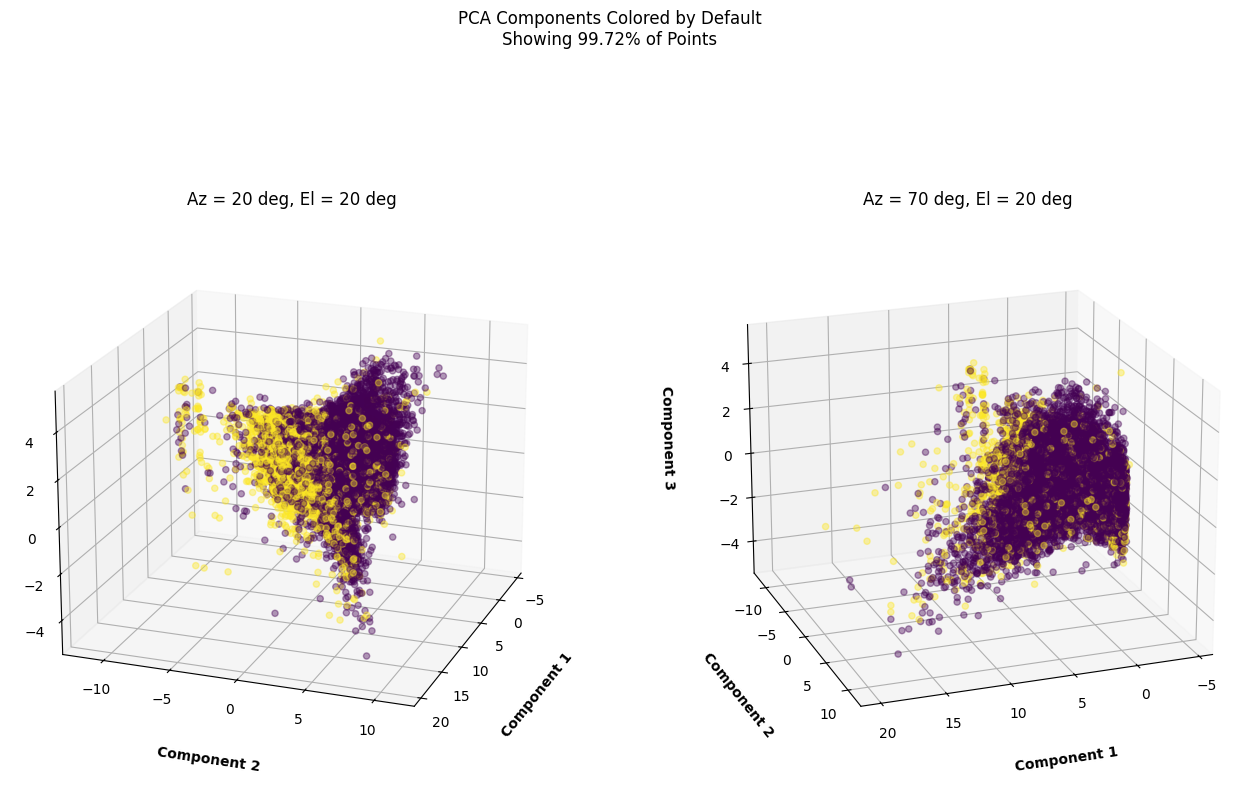

In [85]:
def ax_scatter3D(ax, df: pd.DataFrame = None, az: int = 0, el: int = 0):
    ax.scatter3D(
        df.iloc[:, 0],
        df.iloc[:, 1],
        df.iloc[:, 2],
        c=df[target_var],
        alpha=0.4,
    )
    ax.set_xlabel("Component 1", labelpad=20, fontweight="bold")
    ax.set_ylabel("Component 2", labelpad=20, fontweight="bold")
    ax.set_zlabel("Component 3", labelpad=20, fontweight="bold")
    ax.azim = az
    ax.elev = el
    ax.set_title("Az = %d deg, El = %d deg" % (az, el))


fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 10), subplot_kw=dict(projection="3d")
)

df_pca_3_trim = df_pca_3.query("pca3 <= 5")
ax_scatter3D(ax[0], df=df_pca_3_trim, az=20, el=20)
ax_scatter3D(ax[1], df=df_pca_3_trim, az=70, el=20)

fig.suptitle(
    "PCA Components Colored by Default\nShowing %.2f%% of Points"
    % (len(df_pca_3_trim) / len(df_pca_3) * 100.0)
)

### Analysis

It looks like with 3 features the data is still really mixed together, so no, 3 components does not separate data into clear groups

## PCA with 10 Components

### Fit

In [86]:
df_pca_10 = pd.DataFrame(
    PCA(n_components=10).fit_transform(df_scaled),
    columns=["pca" + str(k + 1) for k in range(10)],
).join(df[target_var])

### Plot

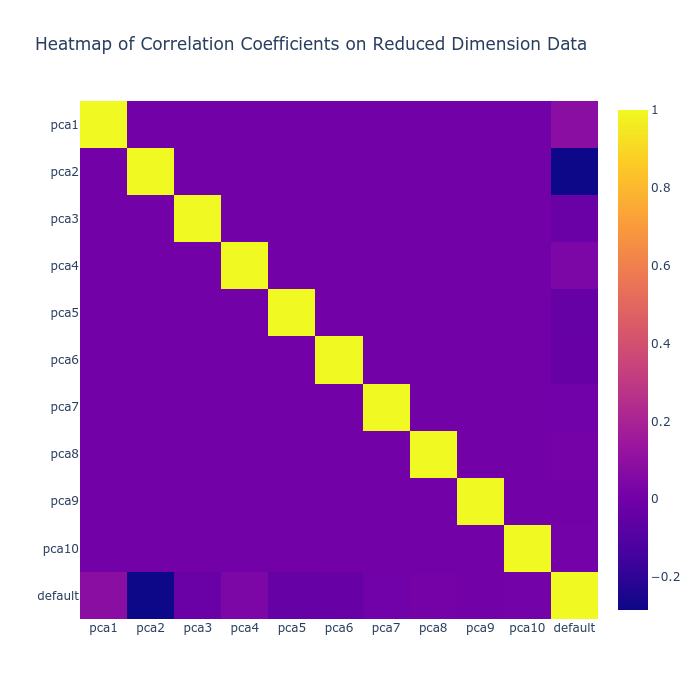

In [87]:
Image(
    px.imshow(
        df_pca_10.corr(),
        title="Heatmap of Correlation Coefficients on Reduced Dimension Data",
        height=700,
        width=700,
    ).to_image()
)

### Analysis

The heatmap of correlation coefficients should show zero everywhere but the diagonal because of the orthogonality of the right singular vectors